In [112]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# EMA
from ema_workbench import (Scenario, Policy, MultiprocessingEvaluator, perform_experiments, ema_logging)
from ema_workbench import Samplers
from ema_workbench import save_results, load_results
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

# Analytical Tools
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

### 0 Run Model
Running Sobol Sampling for (0a) Policy Space and (0b) Uncertainty Space which will be used in sensitivity analysis and scenario discovery.

#### (0a) Sobol Sample Policy Space

In [113]:
%%script false --no-raise-error

# Model Settings
pf = 6
s = 1
p = 256

#------------------------- Initialize Model
model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

#------------------------- Reference Scenario
ref_dict = {'A.1_Bmax':170,
            'A.1_Brate':1.5,
            'A.1_pfail':0.5,
            'A.2_Bmax':170,
            'A.2_Brate':1.5,
            'A.2_pfail':0.5,
            'A.3_Bmax':170,
            'A.3_Brate':1.5,
            'A.3_pfail':0.5,
            'A.4_Bmax':170,
            'A.4_Brate':1.5,
            'A.4_pfail':0.5,
            'A.5_Bmax':170,
            'A.5_Brate':1.5,
            'A.5_pfail':0.5,
            'A.0_ID flood wave shape': 4,
            'discount rate 0': 3.5}

ref_scenario = [Scenario('reference', **ref_dict)]

#------------------------- Run Model
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model, n_processes=6) as evaluator:
    results = evaluator.perform_experiments(scenarios=ref_scenario, policies=p, lever_sampling=Samplers.SOBOL)

save_results(results, 'results/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf,s,p))

Couldn't find program: 'false'


#### (0b) Sobol Sample Scenario Space

In [114]:
%%script false --no-raise-error

# Model Settings
pf = 6
s = 5000
p = 1

#------------------------- Initialize Model
model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

#------------------------- Reference Policy
ref_policy = [Policy('policy 1', **{'0_RfR 0':0,
                                    '1_RfR 0':0,
                                    '2_RfR 0':0,
                                    '3_RfR 0':0,
                                    '4_RfR 0':0,
                                  'A.1_DikeIncrease 0':0,
                                  'A.2_DikeIncrease 0':0,
                                  'A.3_DikeIncrease 0':0,
                                  'A.4_DikeIncrease 0':0,
                                  'A.5_DikeIncrease 0':0,
                                  'EWS_DaysToThreat':0})
                                  ]

#------------------------- Run Model
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model, n_processes=6) as evaluator:
    results = evaluator.perform_experiments(scenarios=s, policies=ref_policy, lever_sampling=Samplers.SOBOL)

save_results(results, 'results/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf,s,p))

Couldn't find program: 'false'


In [115]:
def flatten_dict_arrays(dictionary):
    flattened_dict = {}

    for key, value in dictionary.items():
        flattened_array = []
        for row in value:
            flattened_array.extend(row)
        flattened_dict[key] = flattened_array

    return flattened_dict

### 1 Global Sensivity Analysis

#### (1a1) Feature Scoring (Sample Uncertainty Space)

In [116]:
#sampling scenario
pf, s, p = 6, 5000, 1 

model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

results = load_results('results/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf,s,p))
experiments, outcomes = results
# drop uncertainties
experiments.drop(columns=list(model.levers.keys()), inplace=True)

[MainProcess/INFO] results loaded successfully from c:\Users\ryant\Google Drive\School (TUD)\Semester 4\4_Model-based Decision-making\model-based-decision-making\final_assignment\results\GSA_PF6_S5000_P1_.tar.gz


[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because on

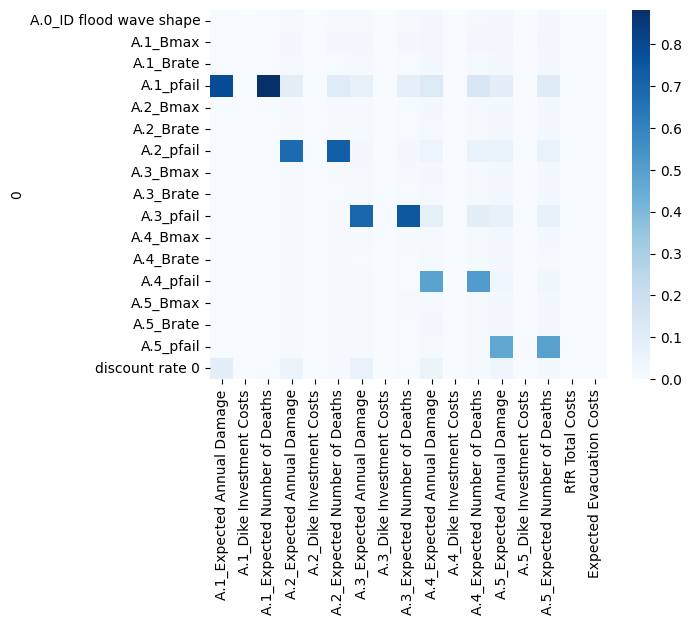

In [117]:
import matplotlib.pyplot as plt

scores = feature_scoring.get_feature_scores_all(experiments, outcomes, mode=RuleInductionType.REGRESSION)
ax = sns.heatmap(scores, annot=False, cmap = "Blues", fmt=".2f")
#ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
#plt.shows()

Feature scores of uncertainities

- **Observations**: In the uncertainty space, probability of dike failure (pfail) is the primary uncertainty that seems to have any influence on any outcome. This uncertainty influences both the damage and deaths in its area. Additionally, a spillover effect is observed as seen from the faint upper triangle on the uncertainty space (see Figure Right). The probability of A1's failure has influenced outcomes on A1-A5 but A5 only influences outcomes on itself. This implies that upstream dike rings seem to have cascading effects on the downstream dike rings. 


- **Interpretation**: This acknowledges the presence of interaction effects through over the observation of spillovers in of the dike failure probabilities. Practically speaking, it will imply a complexity in distribution of cost and benefits, i.e. funding the solution and compensations, if a collaborative solution is created.


#### (1a2) Feature Scoring (Sample Policy Space)

In [118]:
#sampling scenario
pf, s, p = 6, 1, 256 

model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

results = load_results('results/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf,s,p))
experiments, outcomes = results
# drop policies
experiments.drop(columns=list(model.uncertainties.keys())+['policy'], inplace=True)

[MainProcess/INFO] results loaded successfully from c:\Users\ryant\Google Drive\School (TUD)\Semester 4\4_Model-based Decision-making\model-based-decision-making\final_assignment\results\GSA_PF6_S1_P256_.tar.gz


[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a si

<Axes: ylabel='0'>

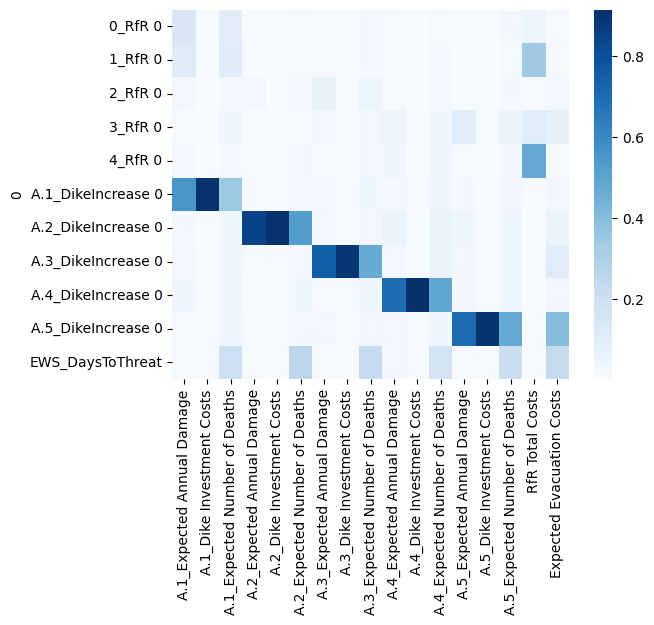

In [119]:
scores = feature_scoring.get_feature_scores_all(experiments, outcomes, mode=RuleInductionType.REGRESSION)
sns.heatmap(scores, annot=False, cmap="Blues")

Feature scores of policies

- **Observations**:
In the policy space, it is apparent that the dike increase policies barely has any influence than RFR for both outcomes of expected deaths and damages. Additionally, it is observed that EWS only influences deaths and not damages.

- **Interpretation**: This draws attention to political implications of the EWS policies beyond the model. The observation that EWS helps with deaths but not damage implies that it cannot be seen as a critical nor comprehensive solution to be considered.


### 2 Scenario Discovery (PRIM)

#### (2a) PRIM (Uncertainities Space)

##### (2a1) Expected Number of Deaths

In [120]:
from ema_workbench.analysis import prim

In [121]:
#sampling scenario
pf, s, p = 6, 5000, 1 

model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

results = load_results('results/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf,s,p))
experiments, outcomes = results
# drop uncertainties
experiments.drop(columns=list(model.levers.keys()), inplace=True)

[MainProcess/INFO] results loaded successfully from c:\Users\ryant\Google Drive\School (TUD)\Semester 4\4_Model-based Decision-making\model-based-decision-making\final_assignment\results\GSA_PF6_S5000_P1_.tar.gz


Dike Ring A.1 

In [122]:
# Set value range
outcome_var = 'A.1_Expected Number of Deaths'

# Set quantile or actual values
max_value = np.quantile(outcomes[outcome_var], 0.8)
min_value = np.quantile(outcomes[outcome_var], 0.2)
logical = np.array([value > max_value for value in outcomes[outcome_var]])

# define prim input parameters
x = experiments
y = logical

# run prim algorithm to find box
prim_alg = prim.Prim(x, logical, threshold=0.6, peel_alpha=0.1)
box_deathsa1 = prim_alg.find_box()

# save scenarios
scenarios_deathsa1 = experiments.iloc[box_deathsa1.yi]

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 5000 points remaining, containing 993 cases of interest
[MainProcess/INFO] mean: 0.7235494880546075, mass: 0.0586, coverage: 0.2134944612286002, density: 0.7235494880546075 restricted_dimensions: 10


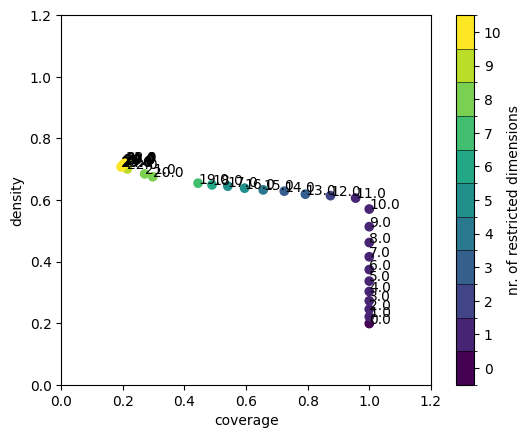

In [123]:
import matplotlib.pyplot as plt
 
box_deathsa1.show_tradeoff(annotated=True)
plt.show()

coverage     0.874119
density      0.613861
id          12.000000
mass         0.282800
mean         0.613861
res_dim      2.000000
Name: 12, dtype: float64

                            box 12                                     
                               min         max  qp value       qp value
A.1_pfail                 0.000141    0.313174       NaN  1.046983e-251
A.0_ID flood wave shape  13.000000  132.000000  0.282218            NaN



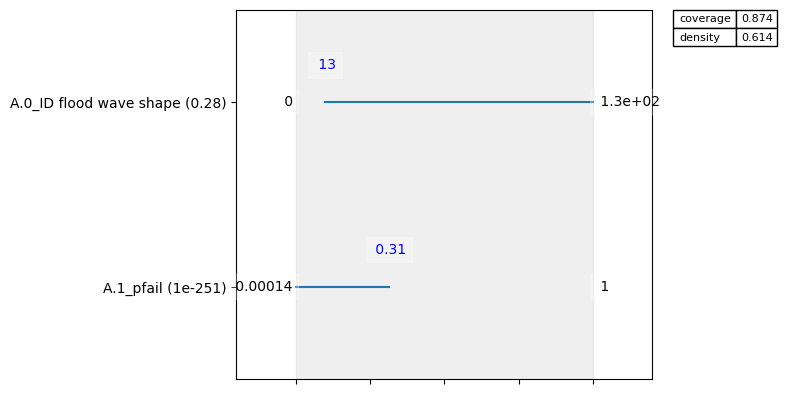

In [124]:
to_inspect = 12

box_deathsa1.inspect(to_inspect)
box_deathsa1.inspect(to_inspect, style='graph')
plt.show()

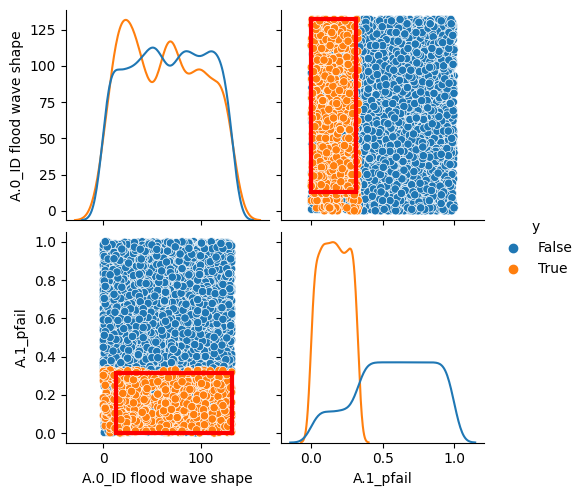

In [125]:
box_deathsa1.select(to_inspect)
fig = box_deathsa1.show_pairs_scatter()
plt.show()

Dike Ring A.2

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 5000 points remaining, containing 1000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.1494, coverage: 0.747, density: 1.0 restricted_dimensions: 2


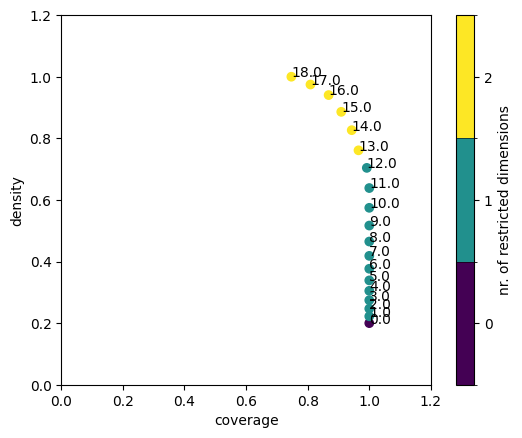

In [126]:
# Set value range
outcome_var = 'A.2_Expected Number of Deaths'

# Set quantile or actual values
max_value = np.quantile(outcomes[outcome_var], 0.8)
min_value = np.quantile(outcomes[outcome_var], 0.2)
logical = np.array([value > max_value for value in outcomes[outcome_var]])

# define prim input parameters
x = experiments
y = logical

# run prim algorithm to find box
prim_alg = prim.Prim(x, logical, threshold=0.6, peel_alpha=0.1)
box_deathsa2 = prim_alg.find_box()

# visualize tradeoff 
box_deathsa2.show_tradeoff(annotated=True)
plt.show()

# save scenarios
scenarios_deathsa2 = experiments.iloc[box_deathsa2.yi]

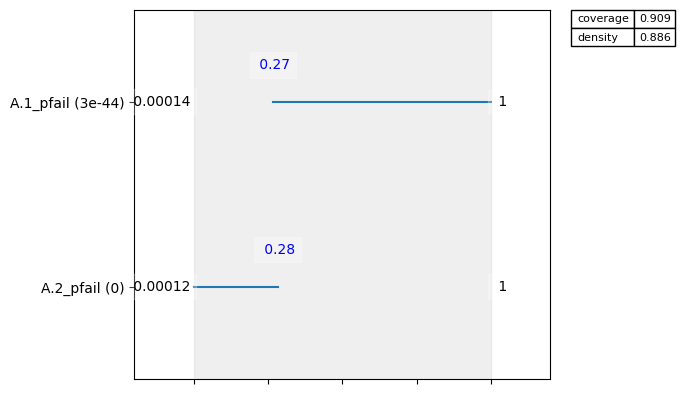

In [127]:
to_inspect = 15
#box1.inspect(to_inspect)
box_deathsa2.inspect(to_inspect, style='graph')
plt.show()

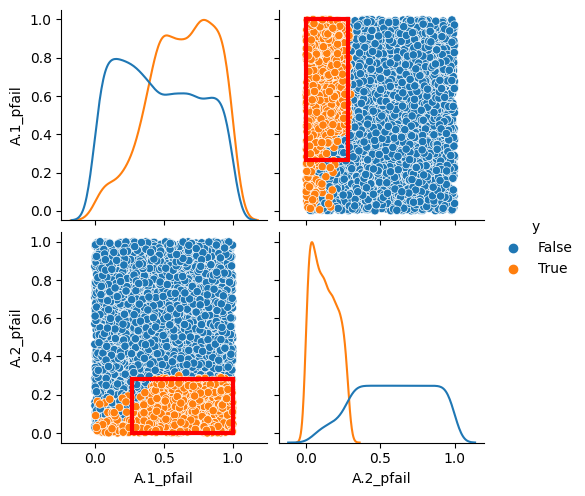

In [128]:
box_deathsa2.select(to_inspect)
fig = box_deathsa2.show_pairs_scatter()
plt.show()

Dike Ring A.3

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 5000 points remaining, containing 1000 cases of interest


[MainProcess/INFO] mean: 1.0, mass: 0.1208, coverage: 0.604, density: 1.0 restricted_dimensions: 3


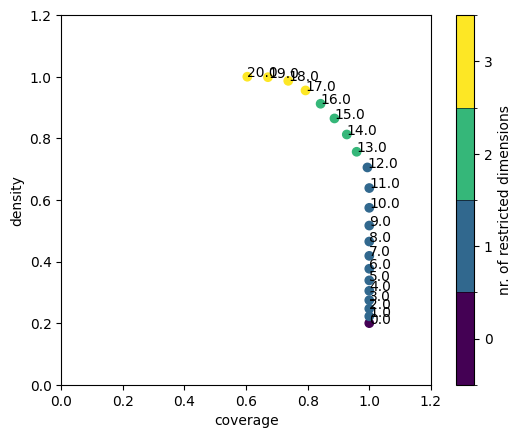

In [129]:
# Set value range
outcome_var = 'A.3_Expected Number of Deaths'

# Set quantile or actual values
max_value = np.quantile(outcomes[outcome_var], 0.8)
min_value = np.quantile(outcomes[outcome_var], 0.2)
logical = np.array([value > max_value for value in outcomes[outcome_var]])

# define prim input parameters
x = experiments
y = logical

# run prim algorithm to find box
prim_alg = prim.Prim(x, logical, threshold=0.6, peel_alpha=0.1)
box_deathsa3 = prim_alg.find_box()

# visualize tradeoff 
box_deathsa3.show_tradeoff(annotated=True)
plt.show()

# save scenarios
scenarios_deathsa3 = experiments.iloc[box_deathsa3.yi]

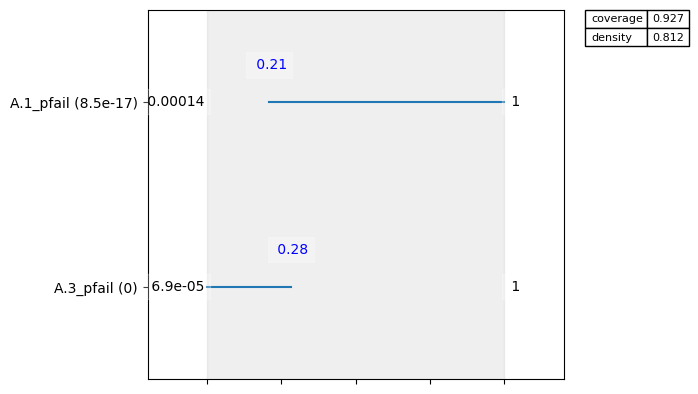

In [130]:
to_inspect = 14
#box1.inspect(to_inspect)
box_deathsa3.inspect(to_inspect, style='graph')
plt.show()

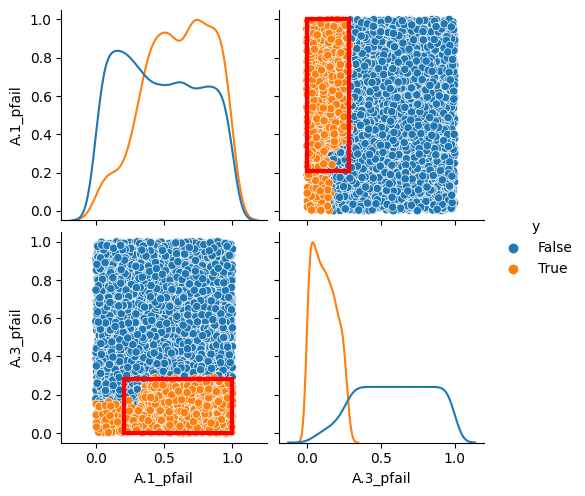

In [131]:
box_deathsa3.select(to_inspect)
fig = box_deathsa3.show_pairs_scatter()
plt.show()

##### (2a2) Expected Damage

Dike Ring A.1

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 5000 points remaining, containing 998 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.1738, coverage: 0.8707414829659319, density: 1.0 restricted_dimensions: 2


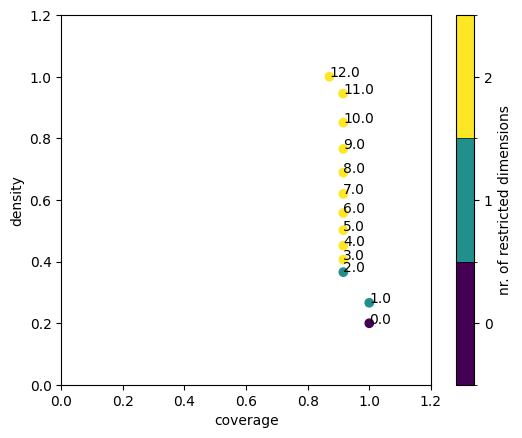

In [132]:
# Set value range
outcome_var = 'A.1_Expected Annual Damage'

# Set quantile or actual values
max_value = np.quantile(outcomes[outcome_var], 0.8)
min_value = np.quantile(outcomes[outcome_var], 0.2)
logical = np.array([value > max_value for value in outcomes[outcome_var]])

# define prim input parameters
x = experiments
y = logical

# run prim algorithm to find box
prim_alg = prim.Prim(x, logical, threshold=0.7, peel_alpha=0.1)
box_damagea1 = prim_alg.find_box()

# visualize tradeoff 
box_damagea1.show_tradeoff(annotated=True)
plt.show()

# save scenarios
scenarios_damagea1 = experiments.iloc[box_damagea1.yi]

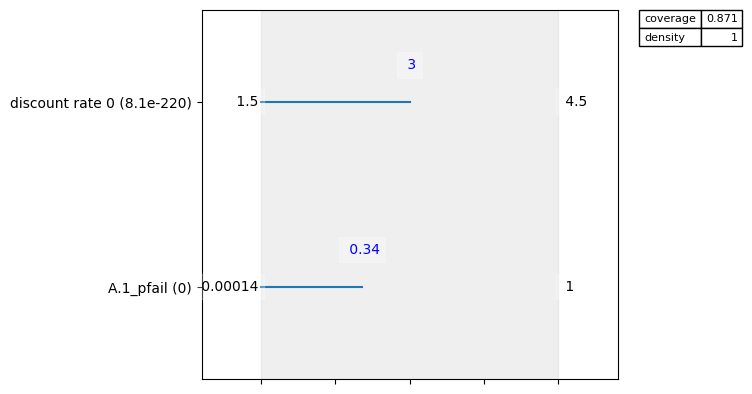

In [133]:
to_inspect = 12
#box1.inspect(to_inspect)
box_damagea1.inspect(to_inspect, style='graph')
plt.show()

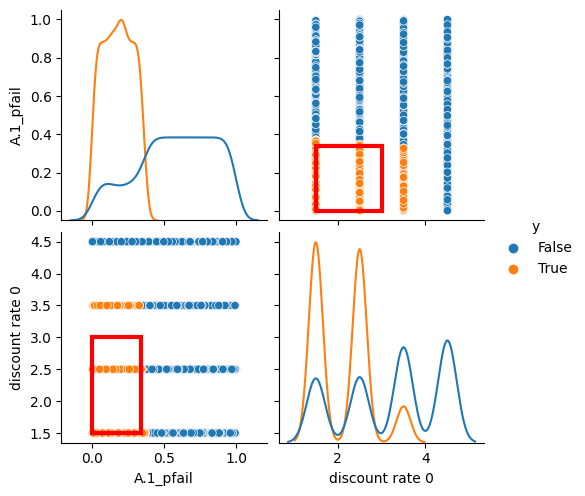

In [134]:
box_damagea1.select(to_inspect)
fig = box_damagea1.show_pairs_scatter()
plt.show()

Dike Ring A.2

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 5000 points remaining, containing 1000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.1086, coverage: 0.543, density: 1.0 restricted_dimensions: 2


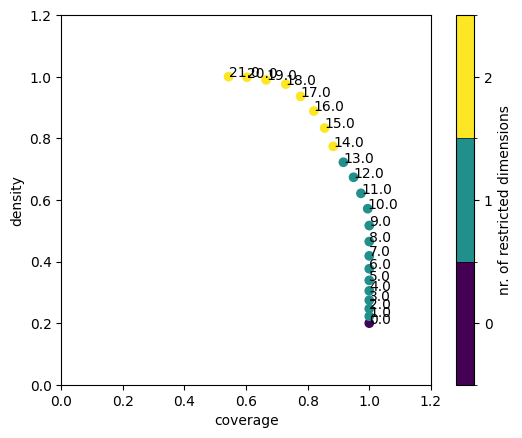

In [135]:
# Set value range
outcome_var = 'A.2_Expected Annual Damage'

# Set quantile or actual values
max_value = np.quantile(outcomes[outcome_var], 0.8)
min_value = np.quantile(outcomes[outcome_var], 0.2)
logical = np.array([value > max_value for value in outcomes[outcome_var]])

# define prim input parameters
x = experiments
y = logical

# run prim algorithm to find box
prim_alg = prim.Prim(x, logical, threshold=0.7, peel_alpha=0.1)
box_damagea2 = prim_alg.find_box()

# visualize tradeoff 
box_damagea2.show_tradeoff(annotated=True)
plt.show()

# save scenarios
scenarios_damagea2 = experiments.iloc[box_damagea2.yi]

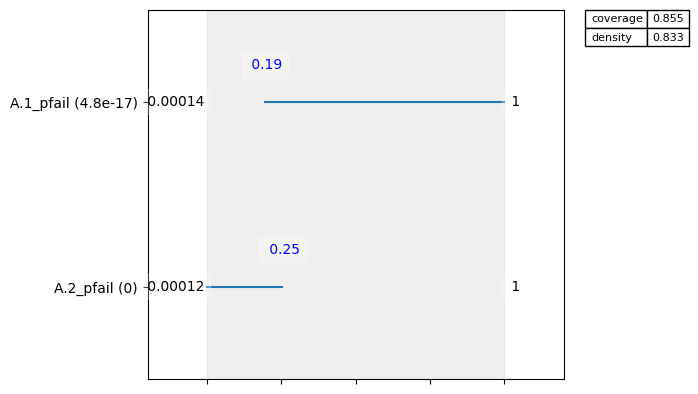

In [136]:
to_inspect = 15
#box1.inspect(to_inspect)
box_damagea2.inspect(to_inspect, style='graph')
plt.show()

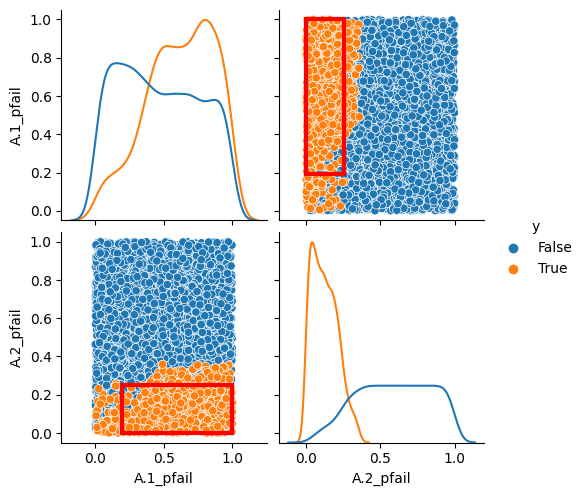

In [137]:
box_damagea2.select(to_inspect)
fig = box_damagea2.show_pairs_scatter()
plt.show()

Dike Ring A.3 

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 5000 points remaining, containing 1000 cases of interest


[MainProcess/INFO] mean: 1.0, mass: 0.1086, coverage: 0.543, density: 1.0 restricted_dimensions: 3


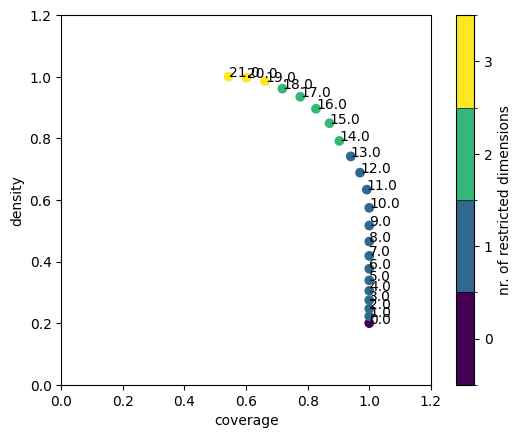

In [138]:
# Set value range
outcome_var = 'A.3_Expected Annual Damage'

# Set quantile or actual values
max_value = np.quantile(outcomes[outcome_var], 0.8)
min_value = np.quantile(outcomes[outcome_var], 0.2)
logical = np.array([value > max_value for value in outcomes[outcome_var]])

# define prim input parameters
x = experiments
y = logical

# run prim algorithm to find box
prim_alg = prim.Prim(x, logical, threshold=0.7, peel_alpha=0.1)
box_damagea3 = prim_alg.find_box()

# visualize tradeoff 
box_damagea3.show_tradeoff(annotated=True)
plt.show()

# save scenarios
scenarios_damagea3 = experiments.iloc[box_damagea3.yi]

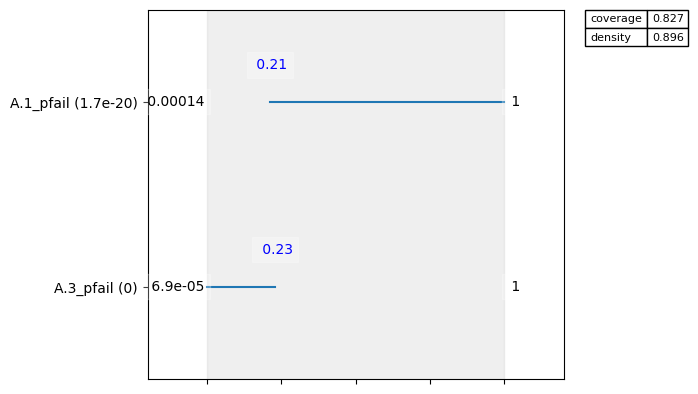

In [139]:
to_inspect = 16
#box1.inspect(to_inspect)
box_damagea3.inspect(to_inspect, style='graph')
plt.show()

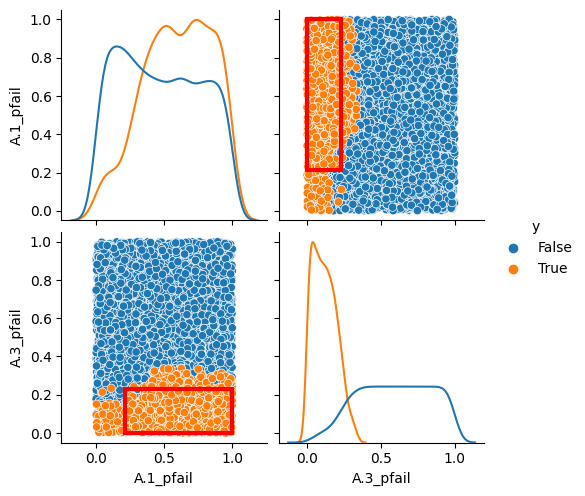

In [140]:
box_damagea3.select(to_inspect)
fig = box_damagea3.show_pairs_scatter()
plt.show()

In [141]:
scenarios_df = pd.concat([scenarios_damagea1,
                scenarios_damagea2,
                scenarios_damagea3,
                scenarios_deathsa1,
                scenarios_deathsa2,
                scenarios_deathsa3], axis=0).drop_duplicates()


scenarios_df.to_csv("results/scenario_gelderland.csv")